<a href="https://colab.research.google.com/github/ariahosseini/TradML/blob/main/ML_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

### Load Modules

In [1]:
!pip install -q import_ipynb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.9 MB/s eta 0:00:00


In [2]:
# utils
import os, sys, warnings, itertools
import import_ipynb
import tarfile
import joblib
import random
import pandas as pd
import numpy as np
from pprint import pprint
# colab
from google.colab import drive
# sklearn
from sklearn.datasets import fetch_openml
from sklearn.model_selection import (train_test_split,
                                     cross_val_score,
                                     cross_val_predict,
                                     GridSearchCV
                                     )
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier,OneVsRestClassifier
from sklearn.metrics import (confusion_matrix,
                             classification_report,
                             precision_score,
                             recall_score,
                             f1_score,
                             accuracy_score,
                             precision_recall_curve,
                             PrecisionRecallDisplay,
                             roc_auc_score,
                             roc_curve
                             )
# vis
import seaborn as sns
import matplotlib.pyplot as plt

### Settings

In [3]:
warnings.filterwarnings("ignore")

In [4]:
%matplotlib inline

In [5]:
# mount google drive
drive.mount("/content/drive")

Mounted at /content/drive


In [6]:
working_path = os.path.abspath(os.path.join("/content/drive/MyDrive/Jupyter Notebooks/"))
os.chdir(working_path)

In [7]:
# load MachineLearningUtils
from MachineLearningUtils import *

## Load Data

In [8]:
mnist = None
data_path = os.path.join(working_path, "Inputs/mnist.pkl")
if os.path.exists(data_path):
    mnist = joblib.load(data_path)
else:
    mnist = fetch_openml("mnist_784", version=1)
    joblib.dump(mnist, data_path)
pprint(mnist.keys(), compact=True)

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [9]:
# load data
X, y = mnist.data, mnist.target.to_frame()
y.columns = ['target']

In [10]:
num_samples = 1000
X = X.sample(n=num_samples, random_state=1)
y = y.sample(n=num_samples, random_state=1)
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

In [11]:
pixel_size = int(np.sqrt(X.shape[1]))

## Model Developement - Clf Five or Not

### Understand Data

In [12]:
display_df(X)

Dataframe:  
num_rows = 1,000 
num_cols = 784


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 784 entries, pixel1 to pixel784
dtypes: int64(784)
memory usage: 6.0 MB


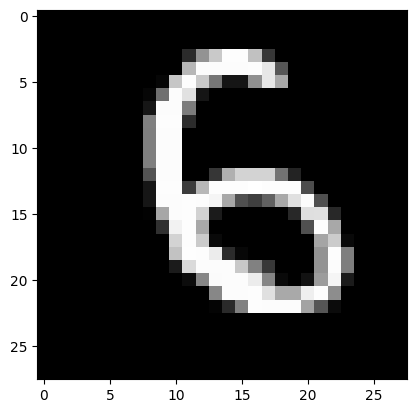

In [13]:
img = X.iloc[0].to_numpy().reshape(pixel_size, pixel_size)
plt.imshow(img, cmap="gray")

In [14]:
pprint(y['target'].dtype)

CategoricalDtype(categories=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], ordered=False, categories_dtype=object)


In [15]:
y['target'] = y['target'].astype(np.uint8)
display_df(y)

Dataframe:  
num_rows = 1,000 
num_cols = 1


,target
0,6
1,2
2,7
3,5
4,7


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   target  1000 non-null   uint8
dtypes: uint8(1)
memory usage: 1.1 KB


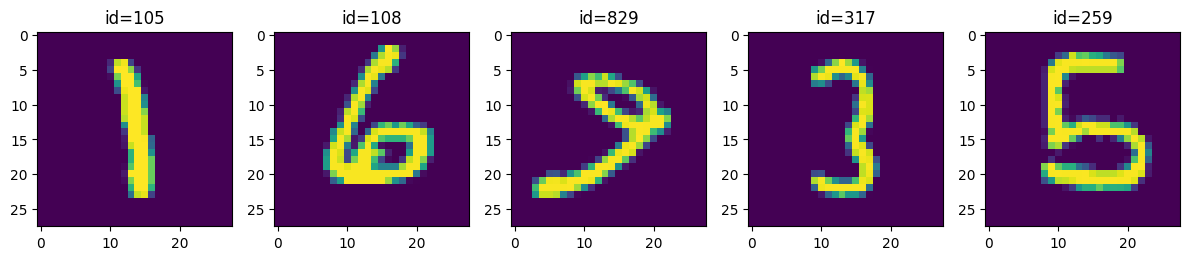

In [16]:
random_img = [random.randint(0, len(X)) for _ in range(5)]
num_rows = 1
num_cols = 5
fig = plt.figure(figsize=(12,14))
for img_num in range(num_rows*num_cols):
    ax = fig.add_subplot(num_rows, num_cols, img_num+1)
    index = random_img[img_num]
    image = X.loc[index, :].to_numpy().reshape(pixel_size, pixel_size)
    ax.imshow(image)
    ax.set_title("id={}".format(index))
plt.tight_layout()

### Define Train and Test Sets

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=2
                                                    )

In [18]:
y_train = np.where(y_train["target"] == 5, 1, 0)
y_test = np.where(y_test["target"] == 5, 1, 0)

### Imputation

In [19]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### SGDClassifier

In [20]:
sgd_clf = SGDClassifier(random_state=42, loss="log_loss")
sgd_clf.fit(X_train, y_train)

SGDClassifier(loss='log_loss', random_state=42)

In [21]:
pprint(sgd_clf._get_param_names())

['alpha',
 'average',
 'class_weight',
 'early_stopping',
 'epsilon',
 'eta0',
 'fit_intercept',
 'l1_ratio',
 'learning_rate',
 'loss',
 'max_iter',
 'n_iter_no_change',
 'n_jobs',
 'penalty',
 'power_t',
 'random_state',
 'shuffle',
 'tol',
 'validation_fraction',
 'verbose',
 'warm_start']


In [22]:
print("Num. of classes:", sgd_clf.classes_)
print("Num. of features:", sgd_clf.n_features_in_)

Num. of classes: [0 1]
Num. of features: 784


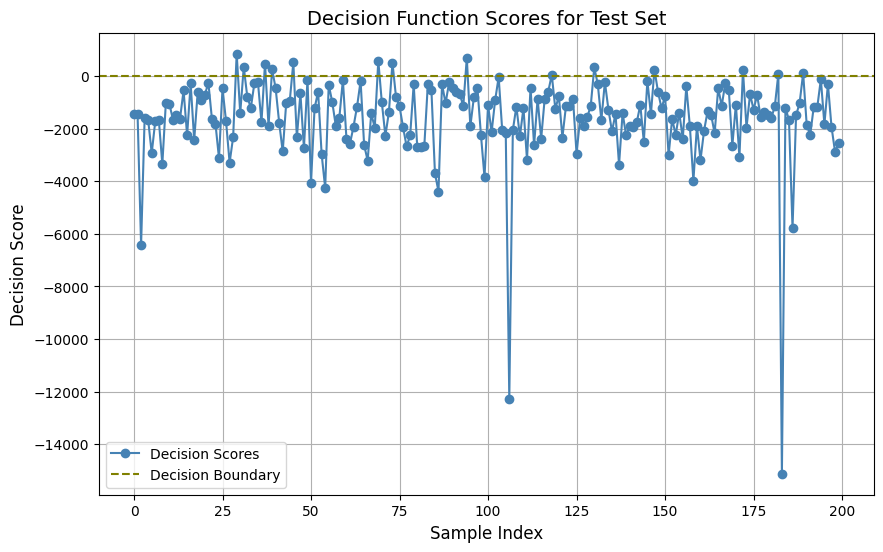

In [23]:
decision_scores = sgd_clf.decision_function(X_test)
plt.figure(figsize=(10, 6))
plt.plot(decision_scores, marker='o', linestyle='-', color='steelblue', label='Decision Scores')
plt.axhline(y=0, color='olive', linestyle='--', label='Decision Boundary')  # Add this line
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Decision Score', fontsize=12)
plt.title('Decision Function Scores for Test Set', fontsize=14)
plt.grid(True)
plt.legend(fontsize=10)
plt.show()

In [24]:
for attr in sgd_clf.__dict__:
    print(f"{attr}: {getattr(sgd_clf, attr)}")

loss: log_loss
penalty: l2
learning_rate: optimal
epsilon: 0.1
alpha: 0.0001
C: 1.0
l1_ratio: 0.15
fit_intercept: True
shuffle: True
random_state: 42
verbose: 0
eta0: 0.0
power_t: 0.5
early_stopping: False
validation_fraction: 0.1
n_iter_no_change: 5
warm_start: False
average: False
max_iter: 1000
tol: 0.001
class_weight: None
n_jobs: None
coef_: [[  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.         -17.16789289
  -17.16789289 -17.16789289   0.           0.         -17.16789289
  -11.5258893  -16.1040028   -1.40760425 -17.16789289 -17.16789289
  -17.16789289   0.           0.           0.           0.
    0.           0.           0.     

In [25]:
methods = [method for method in dir(sgd_clf) if callable(getattr(sgd_clf, method))]
pprint(methods)

['__class__',
 '__delattr__',
 '__dir__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__str__',
 '__subclasshook__',
 '_allocate_parameter_mem',
 '_build_request_for_signature',
 '_check_feature_names',
 '_check_n_features',
 '_check_proba',
 '_fit',
 '_fit_binary',
 '_fit_multiclass',
 '_get_default_requests',
 '_get_doc_link',
 '_get_learning_rate_type',
 '_get_loss_function',
 '_get_metadata_request',
 '_get_param_names',
 '_get_penalty_type',
 '_get_tags',
 '_make_validation_score_cb',
 '_make_validation_split',
 '_more_tags',
 '_more_validate_params',
 '_partial_fit',
 '_predict_proba_lr',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_validate_data',
 '_validate_params',
 'decision_function',
 'densify',
 'fit',
 'ge

In [26]:
sgd_model_score = cross_val_score(sgd_clf,
                                  X_train,
                                  y_train,
                                  cv=10,
                                  scoring="accuracy")

print("Cross-validation scores:", sgd_model_score)
print("Mean accuracy:", sgd_model_score.mean())

Cross-validation scores: [0.9625 0.95   0.95   0.925  0.925  0.95   0.9375 0.925  0.9375 0.975 ]
Mean accuracy: 0.94375


### Naive Model

In [27]:
class NaiveModel(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        random_predictions = np.random.randint(0, 2, size=(len(X), 1))
        return random_predictions.astype(bool)

In [28]:
base_model = NaiveModel()
base_model.fit(X_train)

In [29]:
naive_model_score = cross_val_score(base_model,
                                    X_train,
                                    y_train,
                                    cv=10,
                                    scoring="accuracy")

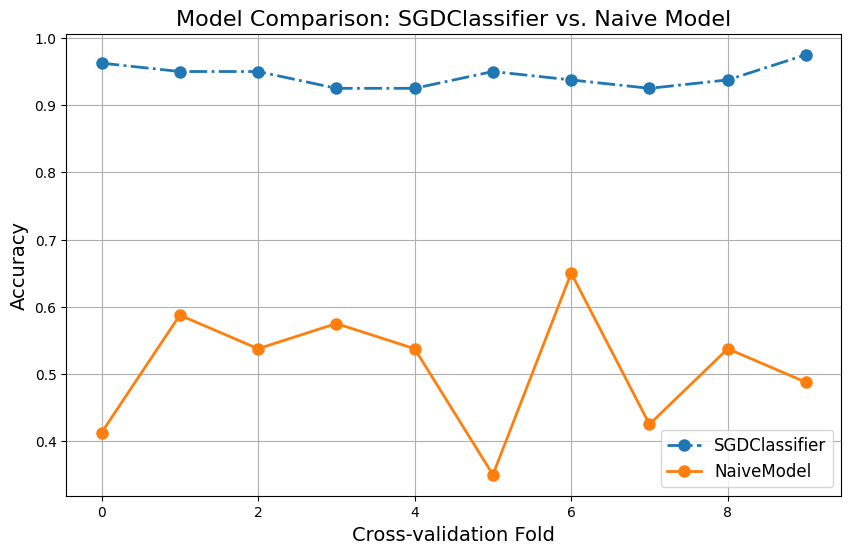

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(sgd_model_score, "o-.", label="SGDClassifier", markersize=8, linewidth=2)
plt.plot(naive_model_score, "o-", label="NaiveModel", markersize=8, linewidth=2)
plt.title("Model Comparison: SGDClassifier vs. Naive Model", fontsize=16)
plt.xlabel("Cross-validation Fold", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

### Predictions

In [31]:
pred_train = cross_val_predict(sgd_clf, X_train, y_train, cv=10)

Confusion matrix, without normalization


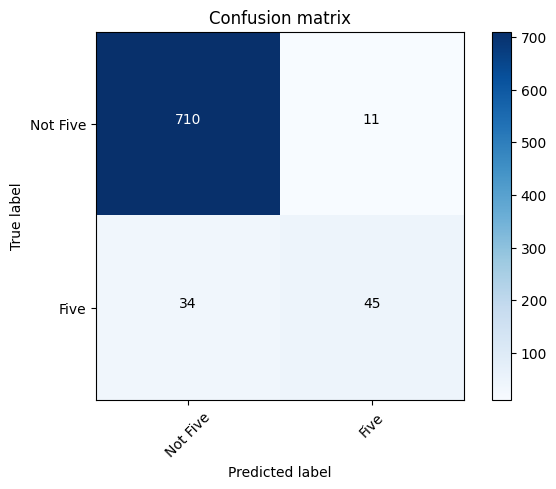

In [32]:
cm = confusion_matrix(y_train, pred_train)
plot_conf_matrix(cm, classes=["Not Five", "Five"], normalize=False, title="Confusion matrix", cmap=plt.cm.Blues)

In [33]:
print("accuracy: {}".format(accuracy_score(y_train, pred_train)))
print("precision: {}".format(precision_score(y_train, pred_train)))
print("recall: {}".format(recall_score(y_train, pred_train)))
print("f1: {}".format(f1_score(y_train, pred_train)))

accuracy: 0.94375
precision: 0.8035714285714286
recall: 0.569620253164557
f1: 0.6666666666666666


In [34]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train, cv=10, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)
thresholds = np.insert(thresholds, 0, thresholds[0])
df = pd.DataFrame({"precision": precisions, "recalls": recalls, "thresholds": thresholds})
df

,precision,recalls,thresholds
0,0.098750,1.000000,-5629.392097
1,0.098874,1.000000,-5629.392097
2,0.098997,1.000000,-4997.530740
3,0.099122,1.000000,-4731.781807
4,0.099246,1.000000,-4721.920161
...,...,...,...
796,1.000000,0.050633,868.498641
797,1.000000,0.037975,868.779083
798,1.000000,0.025316,913.612976
799,1.000000,0.012658,953.152475


<Figure size 1000x600 with 0 Axes>

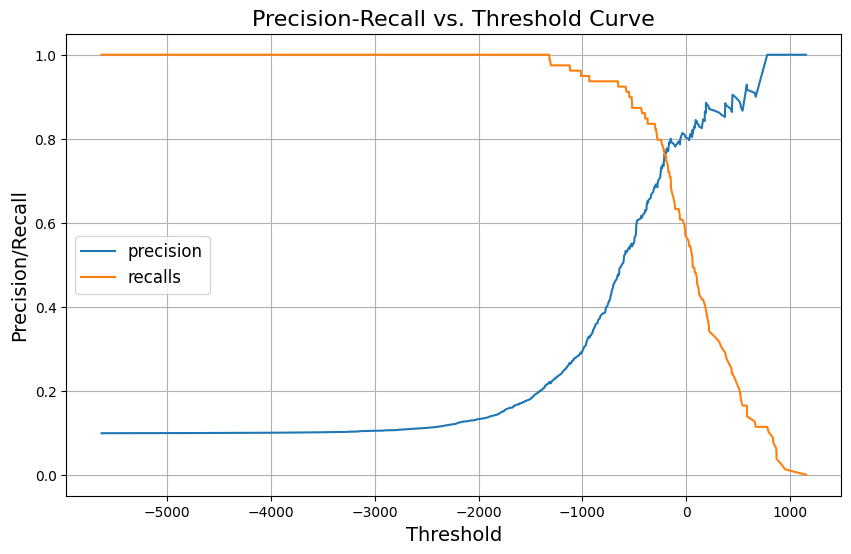

In [35]:
plt.figure(figsize=(10, 6))
df.plot(x="thresholds", y=["precision", "recalls"], figsize=(10, 6))
plt.title("Precision-Recall vs. Threshold Curve", fontsize=16)
plt.xlabel("Threshold", fontsize=14)
plt.ylabel("Precision/Recall", fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

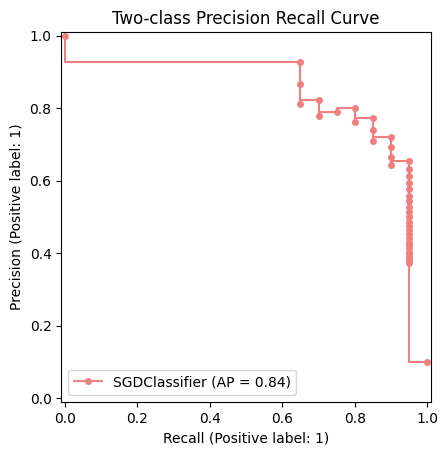

In [36]:
pos_rate_dispaly = PrecisionRecallDisplay.from_estimator(sgd_clf,
                                                         X_test,
                                                         y_test,
                                                         name="SGDClassifier",
                                                         marker="o",
                                                         markersize=4,
                                                         color="lightcoral")
_ = pos_rate_dispaly.ax_.set_title("Two-class Precision Recall Curve")

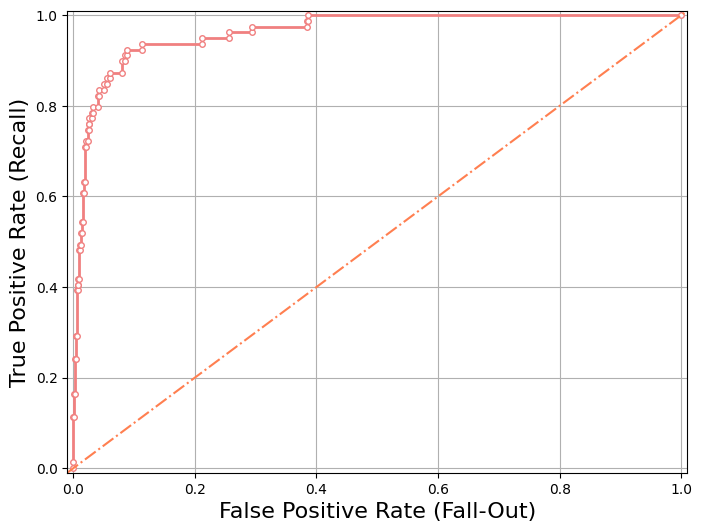

In [37]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, "o-", linewidth=2, label=label, color="lightcoral",
             markersize=4, markerfacecolor="white")
    plt.plot([-0.01, 1.01], [-0.01, 1.01], "coral", linestyle="-.")
    plt.axis([-0.01, 1.01, -0.01, 1.01])
    plt.xlabel("False Positive Rate (Fall-Out)", fontsize=16)
    plt.ylabel("True Positive Rate (Recall)", fontsize=16)
    plt.grid(True)
plt.figure(figsize=(8,6))
plot_roc_curve(fpr, tpr)
plt.show()

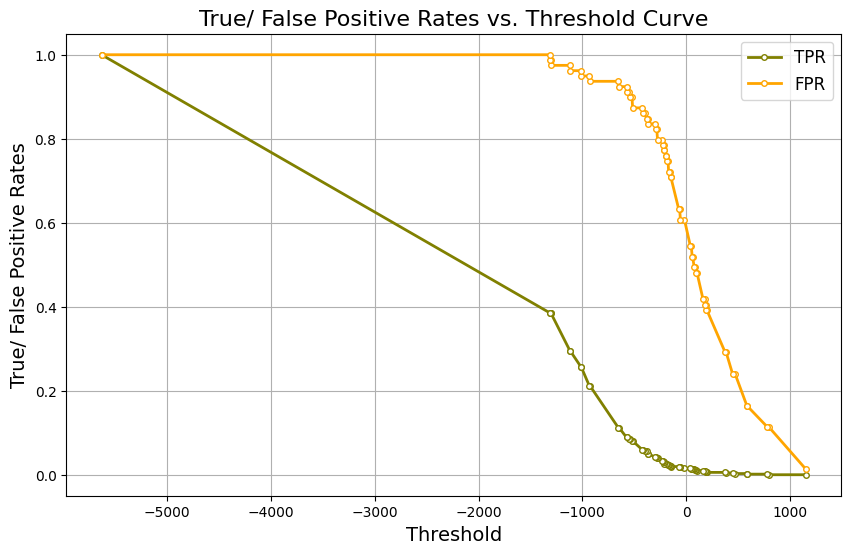

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, fpr, "o-", linewidth=2, label="TPR", color="olive",
             markersize=4, markerfacecolor="white")
plt.plot(thresholds, tpr, "o-", linewidth=2, label="FPR", color="orange",
             markersize=4, markerfacecolor="white")
plt.title("True/ False Positive Rates vs. Threshold Curve", fontsize=16)
plt.xlabel("Threshold", fontsize=14)
plt.ylabel("True/ False Positive Rates", fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

In [39]:
auc = roc_auc_score(y_train, y_scores)
print("AUC:", auc)

AUC: 0.9634473919837075


## Model Developement - Clf One to Nine

### Load Data

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=2
                                                    )

### SGDClassifier

In [41]:
%%time
clf = SGDClassifier(random_state=42, loss="modified_huber")
clf.fit(X_train, y_train)
cross_val_score(clf, X_train, y_train, cv=10, scoring="accuracy")

CPU times: user 2.81 s, sys: 910 ms, total: 3.72 s
Wall time: 2.73 s


array([0.8375, 0.8625, 0.8625, 0.8   , 0.8125, 0.7625, 0.875 , 0.8375,
       0.825 , 0.8375])

In [42]:
y_pred = cross_val_predict(clf, X_train, y_train, cv=10)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95        67
           1       0.88      0.95      0.91        96
           2       0.88      0.82      0.85        89
           3       0.89      0.82      0.85        87
           4       0.79      0.74      0.76        72
           5       0.76      0.71      0.73        79
           6       0.91      0.89      0.90        70
           7       0.87      0.83      0.85        81
           8       0.63      0.78      0.70        73
           9       0.79      0.84      0.81        86

    accuracy                           0.83       800
   macro avg       0.84      0.83      0.83       800
weighted avg       0.84      0.83      0.83       800



Normalized confusion matrix


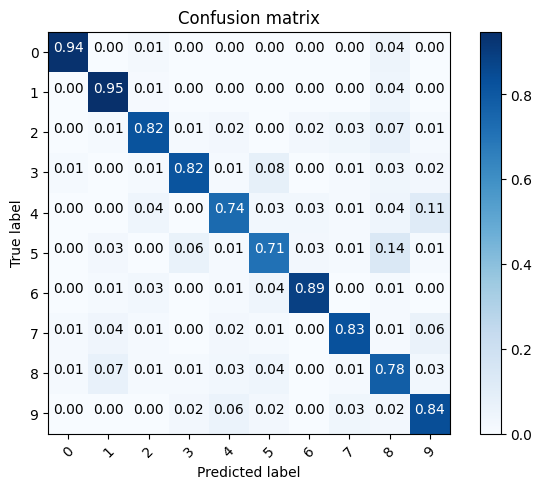

In [43]:
cm = confusion_matrix(y_train, y_pred)
plot_conf_matrix(cm, classes=clf.classes_, normalize=True, title="Confusion matrix", cmap=plt.cm.Blues)

In [44]:
def evaluate_multiclass_clf(y_true, y_pred, average='weighted'):
  """
  Computes accuracy, precision, recall, and F1-score for multi-class classification.

  Args:
    y_true: True labels.
    y_pred: Predicted labels.
    average: Averaging method for precision, recall, and F1-score.
             Default is 'weighted' to account for class imbalance.
             Other options include 'micro', 'macro', and None.

  Returns:
    None (prints the metrics)
  """

  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred, average=average)
  recall = recall_score(y_true, y_pred, average=average)
  f1 = f1_score(y_true, y_pred, average=average)

  print(f"Accuracy: {accuracy:.4f}")
  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1-score: {f1:.4f}")

In [45]:
evaluate_multiclass_clf(y_train, y_pred)

Accuracy: 0.8313
Precision: 0.8363
Recall: 0.8313
F1-score: 0.8323


In [46]:
evaluate_multiclass_clf(y_train, y_pred, average='macro')

Accuracy: 0.8313
Precision: 0.8352
Recall: 0.8300
F1-score: 0.8311


In [47]:
y_score = clf.predict_proba(X_test)
roc_auc = roc_auc_score(y_test.astype("float"), y_score, multi_class='ovr')
print("AUC:", roc_auc)

AUC: 0.9328136818531811


In [48]:
first_digit = X_train.iloc[0]
first_digit_scores = clf.decision_function([first_digit])
first_digit_proba = clf.predict_proba([first_digit])
print("Classes: {}".format(clf.classes_))
print("Score for each class: {}".format(first_digit_scores[0]))
print("Probability for each class: {}".format(first_digit_proba[0]))
print("Class with the highest score: {}".format(np.argmax(first_digit_scores)))

Classes: [0 1 2 3 4 5 6 7 8 9]
Score for each class: [-25512240.81662953 -21490965.73878419 -30185516.68781031
 -42205288.15716676    628881.50642557 -23721909.59488617
  -9414734.47075139 -19821501.18816839 -21886130.58431285
 -22987648.97035512]
Probability for each class: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Class with the highest score: 4


### RandomForestClassifier

In [49]:
%%time
search_space = {
    "n_estimators": [200, 300],
    "max_features": [300, 400],
    "max_depth": [10, 15]
    }
clf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=clf, param_grid=search_space, cv=3,
                           scoring="accuracy", return_train_score=True)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'max_depth': 15, 'max_features': 300, 'n_estimators': 200}
RandomForestClassifier(max_depth=15, max_features=300, n_estimators=200)
CPU times: user 2min 39s, sys: 284 ms, total: 2min 40s
Wall time: 2min 42s


In [50]:
y_pred = grid_search.predict(X_test)

Normalized confusion matrix


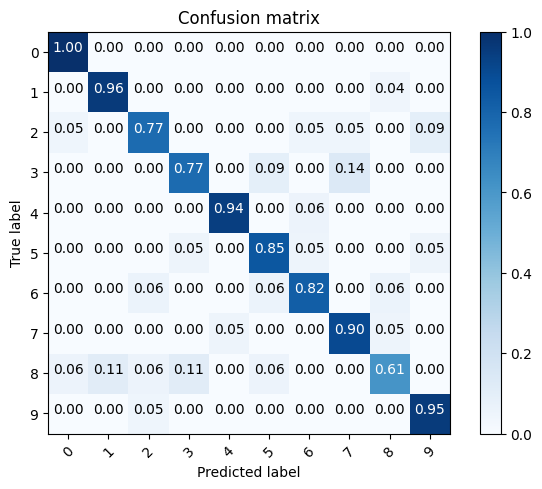

In [51]:
cm = confusion_matrix(y_test, y_pred)
plot_conf_matrix(cm, classes=grid_search.classes_, normalize=True, title="Confusion matrix", cmap=plt.cm.Blues)

In [52]:
evaluate_multiclass_clf(y_test, y_pred, average='macro')

Accuracy: 0.8600
Precision: 0.8571
Recall: 0.8587
F1-score: 0.8557


### OneVsOneClassifier

In [53]:
%%time
one_vs_one_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
one_vs_one_clf.fit(X_train, y_train)

CPU times: user 279 ms, sys: 921 µs, total: 280 ms
Wall time: 292 ms


OneVsOneClassifier(estimator=SGDClassifier(random_state=42))

In [54]:
y_pred = one_vs_one_clf.predict(X_test)

Normalized confusion matrix


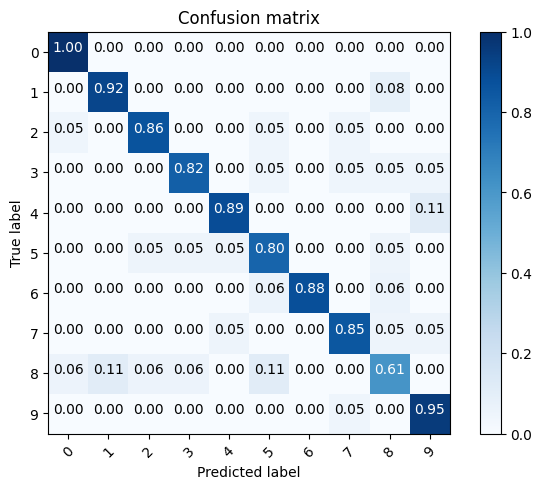

In [55]:
cm = confusion_matrix(y_test, y_pred)
plot_conf_matrix(cm, classes=one_vs_one_clf.classes_, normalize=True, title="Confusion matrix", cmap=plt.cm.Blues)

In [56]:
evaluate_multiclass_clf(y_test, y_pred, average='macro')

Accuracy: 0.8600
Precision: 0.8604
Recall: 0.8585
F1-score: 0.8581


In [57]:
print("First digit is predicted as = {}".format(one_vs_one_clf.predict([first_digit])))
print("Number of estimators = {}".format(len(one_vs_one_clf.estimators_)))

First digit is predicted as = [4]
Number of estimators = 45


### OneVsRestClassifier

In [58]:
%%time
one_vs_rest_clf = OneVsRestClassifier(SGDClassifier(random_state=42))
one_vs_rest_clf.fit(X_train, y_train)

CPU times: user 368 ms, sys: 6.92 ms, total: 375 ms
Wall time: 378 ms


OneVsRestClassifier(estimator=SGDClassifier(random_state=42))

In [59]:
y_pred = one_vs_rest_clf.predict(X_test)

Normalized confusion matrix


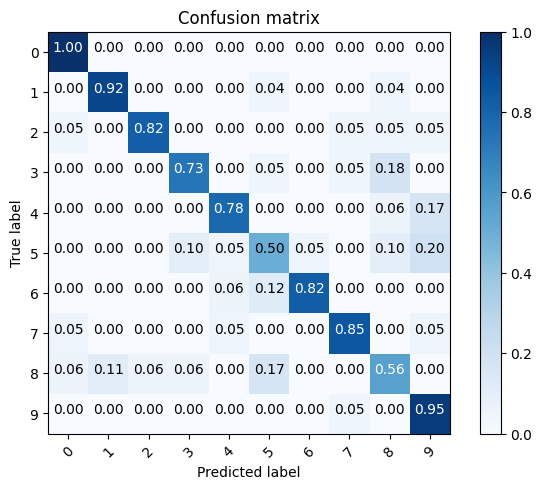

In [60]:
cm = confusion_matrix(y_test, y_pred)
plot_conf_matrix(cm, classes=one_vs_rest_clf.classes_, normalize=True, title="Confusion matrix", cmap=plt.cm.Blues)

In [61]:
evaluate_multiclass_clf(y_test, y_pred, average='macro')

Accuracy: 0.7950
Precision: 0.7978
Recall: 0.7924
F1-score: 0.7908


In [62]:
print("First digit is predicted as = {}".format(one_vs_rest_clf.predict([first_digit])))
print("Number of estimators = {}".format(len(one_vs_rest_clf.estimators_)))

First digit is predicted as = [4]
Number of estimators = 10


## Model Developement - Clf Multi Targets

In [63]:
y_train["target"] = y_train["target"].astype(np.uint8)

In [64]:
Y = np.c_[y_train >= 7, y_train % 2 == 1]#.astype(int)

In [65]:
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, Y)
fifth_digit = X_train.iloc[4]
clf.predict([fifth_digit])

array([[ True, False]])

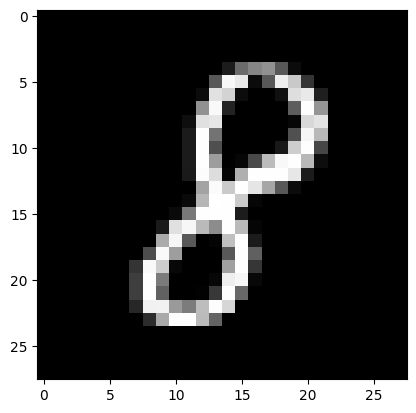

In [66]:
img = fifth_digit.to_numpy().reshape(pixel_size, pixel_size)
plt.imshow(img, cmap="gray")

In [67]:
y_pred = cross_val_predict(clf, X_train, Y, cv=10)

In [68]:
accuracy = accuracy_score(Y, y_pred)
precision = precision_score(Y, y_pred, average=None)
recall = recall_score(Y, y_pred, average=None)
f1 = f1_score(Y, y_pred, average=None)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precisions: {precision[0]:.4f}, {precision[1]:.4f}")
print(f"Recalls: {recall[0]:.4f}, {recall[1]:.4f}")
print(f"F1-scores: {f1[0]:.4f}, {f1[1]:.4f}")

Accuracy: 0.8625
Precisions: 0.9365, 0.9279
Recalls: 0.7375, 0.9301
F1-scores: 0.8252, 0.9290


## Model Development - Batchify

In [69]:
X, y = mnist.data, mnist.target.to_frame()
y.columns = ['target']

In [70]:
X.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    random_state=2
                                                    )

In [72]:
%%time
batch_size = 32  # batch size
n_batches = len(X_train) // batch_size  # number of batches

clf = SGDClassifier()
for batch_index in range(n_batches):
    start = batch_index * batch_size
    end = (batch_index + 1) * batch_size
    X_batch = X_train[start:end]
    y_batch = y_train[start:end]
    clf.partial_fit(X_batch, y_batch, classes=np.unique(y))

CPU times: user 1min 51s, sys: 513 ms, total: 1min 52s
Wall time: 1min 54s


In [73]:
# predictions
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1-score:", f1_score(y_test, y_pred, average='weighted'))

Accuracy: 0.8675
Precision: 0.8789178210078903
Recall: 0.8675
F1-score: 0.8684990672294742


In [74]:
%%time
pred = cross_val_predict(clf, X_test, y_test, cv=5)

CPU times: user 1min 27s, sys: 931 ms, total: 1min 28s
Wall time: 1min 28s


In [75]:
print("accuracy: {}".format(accuracy_score(y_test, pred.astype(float))))
print("precision: {}".format(precision_score(y_test, pred, average="macro")))
print("recall: {}".format(recall_score(y_test, pred, average="micro")))
print("f1: {}".format(f1_score(y_test, pred, average=None)))

accuracy: 0.0
precision: 0.8598389051700286
recall: 0.8598571428571429
f1: [0.9533046  0.94173228 0.84225972 0.82030382 0.86735082 0.74268105
 0.92152628 0.91107325 0.75850223 0.82097649]
